In [84]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

Reading the data


In [89]:
#import data
headers = ['time_utc', 'external_mapping_id', 'active_power_watt','possible_power_watt','wind_speed','rpm','active_stop','control_state_id','online_data_expired','wind_direction','temperature','active_stop_user_id','received_time_utc']

parse_dates = ['time_utc', 'received_time_utc']
df = pd.read_csv("../../AssetsData/new_online_data.csv", sep=',', names=headers, parse_dates=parse_dates, skiprows=1)


# dropping empty values
df.dropna(subset=['wind_speed', 'temperature', 'wind_direction'], inplace=True, axis=0)
indexNames = df[df['rpm'] < 0 ].index
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

df = df[['external_mapping_id','time_utc','active_power_watt']]
df.columns = ['id', 'time_utc', 'active_power_watt']
dtypes = {
    'id':np.uint8,
    'active_power_watt':np.int64
}
df = df.astype(dtypes)

# specifying an ID to do this for
df = df[df['id'] == 93]
cond1 = (df.time_utc > pd.Timestamp(2022,3,2,8,12)) & (df.time_utc < pd.Timestamp(2022,3,29,13,36))
df = df.loc[cond1]

df.sort_values(by='time_utc', ascending=True, inplace=True)
# and rename the control state ids to more meaningful values
df.info()

/Users/miroslavmarinov/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 61765 entries, 714807 to 160393
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 61765 non-null  uint8         
 1   time_utc           61765 non-null  datetime64[ns]
 2   active_power_watt  61765 non-null  int64         
dtypes: datetime64[ns](1), int64(1), uint8(1)
memory usage: 1.5 MB


In [90]:
df = df.set_index('time_utc')
#print(f'Number of rows with missing values: {df.isnull().any(axis=1)}')
df = df.sort_index()
df.index = df.index.round('30s')

In [91]:
df[df.index.duplicated()]
df = df[~df.index.duplicated()]
df

id  active_power_watt
time_utc                                  
2022-03-02 08:12:30  93             319300
2022-03-02 08:13:00  93             323800
2022-03-02 08:13:30  93             346400
2022-03-02 08:14:00  93             327600
2022-03-02 08:14:30  93             335700
...                  ..                ...
2022-03-29 13:21:30  93            1017600
2022-03-29 13:25:30  93            1974500
2022-03-29 13:26:00  93            2286200
2022-03-29 13:28:00  93            1432400
2022-03-29 13:34:30  93            1058000

[60959 rows x 2 columns]

In [92]:
df = df.asfreq(freq='30S')
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')
df = df.interpolate()
df

Number of rows with missing values: 0.22251131943115873


id  active_power_watt
time_utc                                    
2022-03-02 08:12:30  93.0           319300.0
2022-03-02 08:13:00  93.0           323800.0
2022-03-02 08:13:30  93.0           346400.0
2022-03-02 08:14:00  93.0           327600.0
2022-03-02 08:14:30  93.0           335700.0
...                   ...                ...
2022-03-29 13:32:30  93.0          1173200.0
2022-03-29 13:33:00  93.0          1144400.0
2022-03-29 13:33:30  93.0          1115600.0
2022-03-29 13:34:00  93.0          1086800.0
2022-03-29 13:34:30  93.0          1058000.0

[78405 rows x 2 columns]

Splitting the data into test and train data and plotting it.

Train dates : 2022-03-02 08:12:30 --- 2022-03-26 03:54:30  (n=68605)
Test dates  : 2022-03-26 03:55:00 --- 2022-03-29 13:34:30  (n=9800)


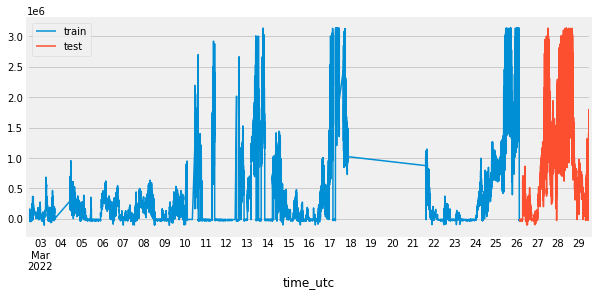

In [98]:
steps = 9800
data_train = df[:-steps]
data_test  = df[-steps:]
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['active_power_watt'].plot(ax=ax, label='train')
data_test['active_power_watt'].plot(ax=ax, label='test')
ax.legend()

In [99]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123), lags = 120)

forecaster.fit(y=data_train['active_power_watt'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120] 
Window size: 120 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2022-03-02 08:12:30'), Timestamp('2022-03-26 03:54:30')] 
Training index type: DatetimeIndex 
Training index frequency: 30S 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples

In [76]:
# Predictions
# ==============================================================================
steps = 9800
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2022-03-22 14:56:00    137792.232607
2022-03-22 14:56:30    124630.788622
2022-03-22 14:57:00    119699.000000
2022-03-22 14:57:30    114984.580404
2022-03-22 14:58:00    118518.638889
Freq: 30S, Name: pred, dtype: float64

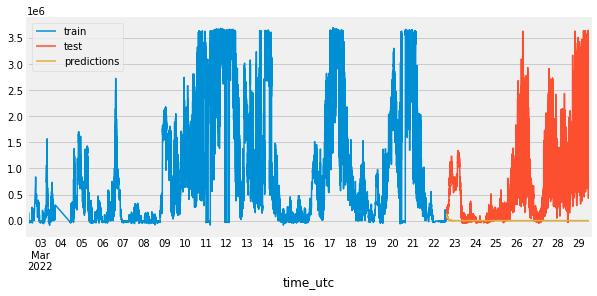

In [77]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['active_power_watt'].plot(ax=ax, label='train')
data_test['active_power_watt'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [38]:
error_mse = mean_squared_error(
                y_true = data_test['active_power_watt'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

ValueError: Found input variables with inconsistent numbers of samples: [14400, 3000]